In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.auto import tqdm
import pandas as pd

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks
!unzip tesla.zip

/content/drive/MyDrive/Colab Notebooks
Archive:  tesla.zip
replace TSLA.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: TSLA.csv                


In [ ]:


df = pd.read_csv('TSLA.csv')
print(df.shape)
df.head()


(1258, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


In [ ]:
# for univariate
x_data=df.iloc[: , 4:5].values
y_data=df.iloc[: , 4:5].values
scaler = MinMaxScaler(feature_range=(0, 1))
x_data=scaler.fit_transform(x_data)
y_data=scaler.fit_transform(y_data)

x = pd.DataFrame(x_data)
y = pd.DataFrame(y_data)


print(x_data)

[[0.01053705]
 [0.01044971]
 [0.01051345]
 ...
 [0.79314193]
 [0.81017257]
 [0.80417701]]


In [ ]:
# for multivariate
x_data=df.drop(['Close','Date'], axis=1)
y_data=df.iloc[: , 4:5].values
scaler = MinMaxScaler(feature_range=(0, 1))
x_data=scaler.fit_transform(x_data)
y_data=scaler.fit_transform(y_data)

print(x_data)

[[0.01038168 0.00983492 0.01110258 0.01053705 0.01024978]
 [0.01011039 0.00928828 0.01095669 0.01044971 0.00215252]
 [0.00999111 0.00948053 0.0108347  0.01051345 0.00092781]
 ...
 [0.79106836 0.78548941 0.79982115 0.79314193 0.00507125]
 [0.78361947 0.79431443 0.79406895 0.81017257 0.03090995]
 [0.80393145 0.80253726 0.81193545 0.80417701 0.02834514]]


In [ ]:
class CustomDataset(Dataset):
    def __init__(self,x_train, y_train,sequence_length):
        self.x_train = x_train
        self.y_train = y_train
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.x_train) - self.sequence_length

    def __getitem__(self, index):
        x = self.x_train[index:index+self.sequence_length]
        y = self.y_train[index+self.sequence_length]
        feature=torch.tensor(x,dtype=torch.float)
        labels=torch.tensor(y,dtype=torch.float)
        return feature, labels

In [ ]:

seq_length=8

dataset=CustomDataset(x_data,y_data, seq_length)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
#train_data, test_data = random_split(dataset, [train_size, test_size])
train_data = torch.utils.data.Subset(dataset, range(train_size))
test_data = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

train_dataloader = DataLoader(train_data ,batch_size=16, shuffle=True)
test_dataloader=DataLoader(test_data ,batch_size=8, shuffle=False)







In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # init hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)

        # init cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out

In [ ]:
class GRU(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(x.device)

        # Propagate input through GRU
        ula, h_out = self.gru(x, h_0)

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [ ]:
def train_step(model: torch.nn.Module,
dataloader: torch.utils.data.DataLoader,
loss_fn: torch.nn.Module,
optimizer: torch.optim.Optimizer,
device: torch.device):

        model.train()
        train_loss=[]
        train_mae =[]
        train_r2 = []
        r2=0


        for batch, (X, y) in enumerate(dataloader):
              X, y = X.to(device), y.to(device)
              y_pred = model(X)
              loss = loss_fn(y_pred, y)
              f=F.l1_loss(y_pred, y, reduction='sum')
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

              train_loss.append(loss.item()* X.size(0))
              train_mae.append (f.item())

              variance = torch.sum((y - torch.mean(y)) ** 2)
              residual_variance = torch.sum((y_pred - y) ** 2)
              r2 = 1 - (residual_variance / variance)
              train_r2.append(r2.clone())



        train_loss =sum(train_loss) / len(train_loss)
        train_mae = sum(train_mae) / len(train_mae)
        train_r2 =sum(train_r2) / len(train_r2)
        return train_loss , train_mae ,train_r2










def test_step(model: torch.nn.Module,
dataloader: torch.utils.data.DataLoader,
loss_fn: torch.nn.Module,
device: torch.device):

        model.eval()
        test_loss =[]
        test_mae =[]
        test_r2 =[]
        r2=0

        with torch.inference_mode():
          for batch, (X, y) in enumerate(dataloader):
              X, y = X.to(device), y.to(device)
              y_pred = model(X)
              loss = loss_fn(y_pred, y)
              f=F.l1_loss(y_pred, y, reduction='sum')


              test_loss.append(loss.item()* X.size(0))
              test_mae.append(f.item())
              variance = torch.sum((y - torch.mean(y)) ** 2)
              residual_variance = torch.sum((y_pred - y) ** 2)
              r2 = 1 - (residual_variance / variance)
              test_r2.append(r2.clone())




        test_loss = sum(test_loss) / len(test_loss)
        test_mae = sum(test_mae) / len(test_mae)
        test_r2 = sum(test_r2) / len(test_r2)
        return test_loss , test_mae ,test_r2












def train(model: torch.nn.Module,
train_dataloader: torch.utils.data.DataLoader,
test_dataloader: torch.utils.data.DataLoader,
optimizer: torch.optim.Optimizer,
loss_fn: torch.nn.Module,
epochs: int,
device: torch.device):

  model.to(device)


  results = {"train_loss": [],"train_mae": [],"train_r2": [],
  "test_loss": [] , "test_mae": [] , "test_r2": []
  }

  for epoch in tqdm(range(epochs)):


      train_loss, train_mae , train_r2 = train_step(model=model,
      dataloader=train_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      device=device)


      test_loss, test_mae , test_r2 = test_step(model=model,
      dataloader=test_dataloader,
      loss_fn=loss_fn,
      device=device)



      print(
      f"Epoch: {epoch + 1} | "

      f"train_loss: {train_loss:.4f} | "
      f"train_mae: {train_mae:.4f} | "
      f"train_r2: {train_r2:.4f} | "

      f"test_loss: {test_loss:.4f}|"
      f"test_mae: {test_mae:.4f} | "
      f"test_r2: {test_r2:.4f} | "
      )



      results["train_loss"].append(train_loss)
      results["train_mae"].append(train_mae)
      results["train_r2"].append(train_r2)

      results["test_loss"].append(test_loss)
      results["test_mae"].append(test_mae)
      results["test_r2"].append(test_r2)
  return results





def plot_loss_curves(results, title):



  train_loss =results["train_loss"]
  test_loss = results["test_loss"]
  train_mae =results["train_mae"]
  test_mae = results["test_mae"]
  train_r2 = torch.tensor(results["train_r2"])
  test_r2 = torch.tensor(results["test_r2"])




  epochs = range(len(results["train_loss"]))
  plt.figure(figsize=(12, 8))
  plt.suptitle(title, fontsize=15)


  # Plot loss
  plt.subplot(2, 2, 1)
  plt.plot(epochs, train_loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

   #Plot mae
  plt.subplot(2, 2, 2)
  plt.plot(epochs, train_mae, label="train_mae")
  plt.plot(epochs, test_mae, label="test_mae")
  plt.title("mae")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot r2
  plt.subplot(2, 2, 3)
  plt.plot(epochs, train_r2, label="train_r2")
  plt.plot(epochs, test_r2, label="test_r2")
  plt.axhline(0, color="k", linestyle="--")
  plt.title("R2 Score")
  plt.xlabel("Epochs")
  plt.ylabel("R2 Score")
  plt.legend()

  plt.tight_layout()
  plt.show()








def plot_comparesion(model: torch.nn.Module,
                     dataloader: torch.utils.data.DataLoader,
                     device: torch.device):







  model.eval()

  with torch.no_grad():
    y_preds = []
    true_labels = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        x, y = x.to(device), y.to(device)
        y_pred = model(x)

        y_preds.extend(y_pred.cpu().numpy())
        true_labels.extend(y.cpu().numpy())

  y_preds = np.array(y_preds)
  true_labels = np.array(true_labels)

  y_preds=scaler.inverse_transform(y_preds)
  true_labels=scaler.inverse_transform(true_labels)

  plt.plot(y_preds, label='Predicted')
  plt.plot(true_labels, label='True Labels')
  plt.xlabel('Sample')
  plt.ylabel('Value')
  plt.legend()
  plt.show()
  plt.scatter(range(len(y_preds)), y_preds, label='Predicted')
  plt.scatter(range(len(true_labels)), true_labels, label='True Labels')
  plt.xlabel('Sample')
  plt.ylabel('Value')
  plt.legend()
  plt.show()


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# parametere setting for univariable


num_epochs = 100
learning_rate = 0.01
input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

LSTM_model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
GRU_model = GRU(num_classes, input_size, hidden_size, num_layers).to(device)
criterion = torch.nn.MSELoss()
optimizer_ltsm = torch.optim.Adam(LSTM_model.parameters(), lr=learning_rate)
optimizer_gru = torch.optim.Adam(GRU_model.parameters(), lr=learning_rate)







In [ ]:
# parametere setting for multi_variable


num_epochs = 100
learning_rate = 0.01
input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1

LSTM_model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
GRU_model = GRU(num_classes, input_size, hidden_size, num_layers).to(device)
criterion = torch.nn.MSELoss()
optimizer_ltsm = torch.optim.Adam(LSTM_model.parameters(), lr=learning_rate)
optimizer_gru = torch.optim.Adam(GRU_model.parameters(), lr=learning_rate)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0847 | train_mae: 0.7436 | train_r2: -2.7531 | test_loss: 1.8882|test_mae: 3.6903 | test_r2: -2081.6777 | 
Epoch: 2 | train_loss: 0.0141 | train_mae: 0.2692 | train_r2: 0.6533 | test_loss: 0.9893|test_mae: 2.5934 | test_r2: -1112.8657 | 
Epoch: 3 | train_loss: 0.0029 | train_mae: 0.1159 | train_r2: 0.9012 | test_loss: 0.7592|test_mae: 2.1916 | test_r2: -860.9250 | 
Epoch: 4 | train_loss: 0.0012 | train_mae: 0.0766 | train_r2: 0.9723 | test_loss: 0.6602|test_mae: 2.0137 | test_r2: -749.1908 | 
Epoch: 5 | train_loss: 0.0008 | train_mae: 0.0611 | train_r2: 0.9770 | test_loss: 0.5833|test_mae: 1.8850 | test_r2: -660.8588 | 
Epoch: 6 | train_loss: 0.0008 | train_mae: 0.0614 | train_r2: 0.9779 | test_loss: 0.5319|test_mae: 1.7914 | test_r2: -602.0499 | 
Epoch: 7 | train_loss: 0.0007 | train_mae: 0.0572 | train_r2: 0.9773 | test_loss: 0.4739|test_mae: 1.6829 | test_r2: -536.3876 | 
Epoch: 8 | train_loss: 0.0007 | train_mae: 0.0540 | train_r2: 0.9727 | test_loss: 0.422

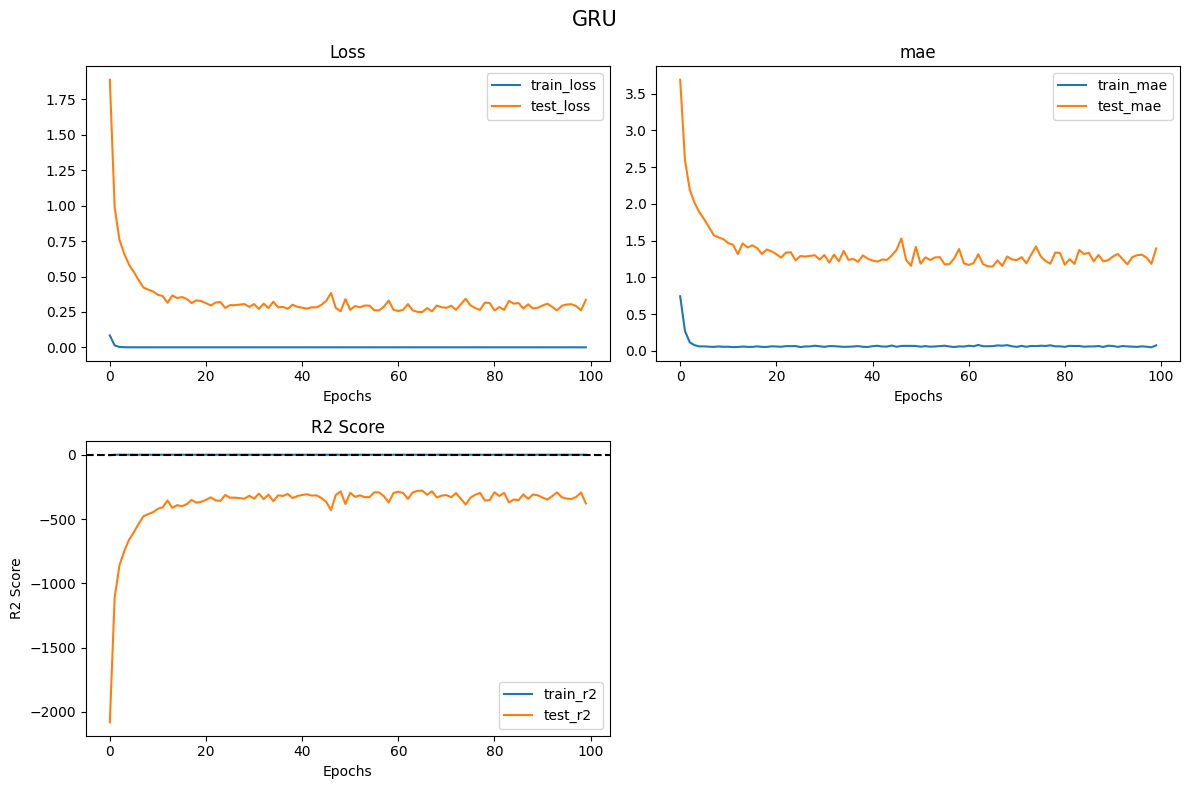

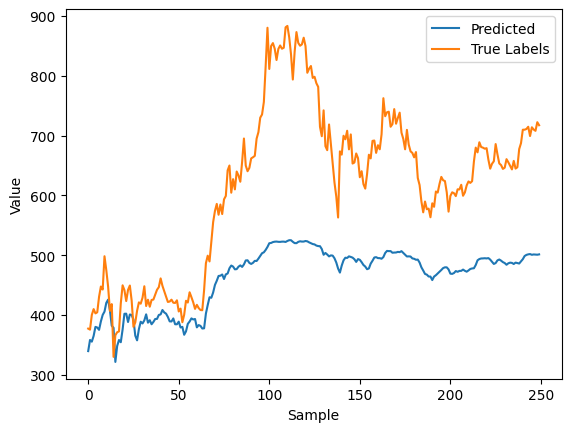

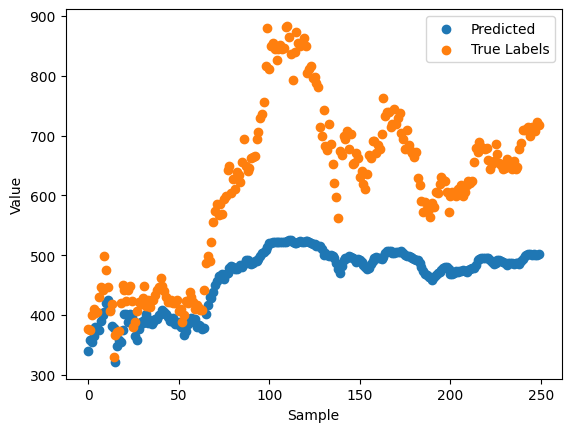

In [ ]:
results_GRU_model = train(
GRU_model,
train_dataloader,
test_dataloader,
optimizer_gru,
criterion,
num_epochs,
device=device)
plot_loss_curves(results_GRU_model, title="GRU")
plot_comparesion(GRU_model,test_dataloader, device)

In [ ]:
results_LSTM_model = train(
LSTM_model,
train_dataloader,
test_dataloader,
optimizer_ltsm,
criterion,
num_epochs,
device=device)


plot_loss_curves(results_LSTM_model, title="LSTM")
plot_comparesion(LSTM_model,test_dataloader, device)

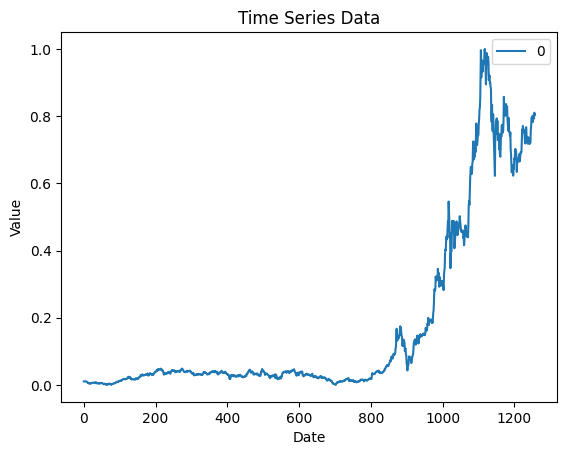

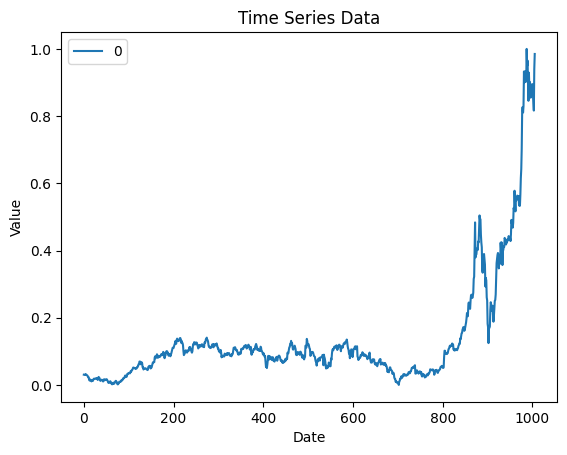

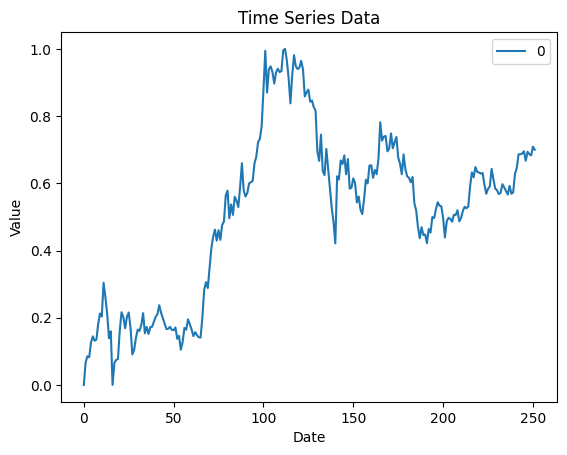

In [ ]:
# for ARIMA model



df = pd.read_csv('TSLA.csv')
data= df[['Close']]

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data = data[:train_size]
test_data = data[train_size:train_size + test_size]





scaler = MinMaxScaler(feature_range=(0, 1))
data=scaler.fit_transform(data.values.reshape(-1, 1))
train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data = scaler.fit_transform(test_data.values.reshape(-1, 1))

data=pd.DataFrame(data)
train_dataframe=pd.DataFrame(train_data)
test_dataframe=pd.DataFrame(test_data)





data.plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data')
train_dataframe.plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data')
test_dataframe.plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()


In [ ]:
!pip install pmdarima
import pmdarima as pm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model = pm.auto_arima(data, trace=True , suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7295.460, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7287.659, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7292.556, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7292.705, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7286.832, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7289.137, Time=1.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7288.897, Time=3.83 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-7295.915, Time=2.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7290.857, Time=0.77 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-7296.831, Time=3.51 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-7296.901, Time=5.00 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-7290.838, Time=1.61 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-7299.750, Time=1.71 sec
 ARIMA(5,1,2)(0,0,0)[0] i

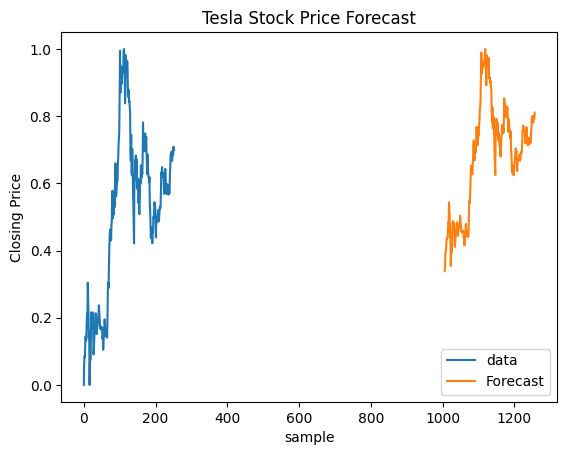

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt




model = ARIMA(data, order=(5, 1, 3))
model = model.fit()


start=len(train_dataframe)
end=len(train_dataframe)+len(test_dataframe)-1
forecast = model.predict(start=start , end=end , typ="levels")
forecast_dataframe=pd.DataFrame(forecast)


plt.plot(test_dataframe, label='data')
plt.plot(forecast_dataframe, label='Forecast')
plt.title('Tesla Stock Price Forecast')
plt.xlabel('sample')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

